# Data Exploration

In [1]:
import numpy as np

from cellgroup.data.io import load_images
from cellgroup.data.utils import WellID, ChannelID

In [28]:
DATA_DIR = "/group/jug/federico/data/Cellgroup/"
img_dict = load_images(
    data_dir=DATA_DIR, 
    well_ids=[WellID.A06], 
    channel_ids=[ChannelID.Ch1, ChannelID.Ch13], 
    t_steps_subsample=(32, 42, 2)
)

Loading images for WellWellID.A06-ChannelID.Ch13: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]


In [29]:
{key: img.shape for key, img in img_dict[WellID.A06].items()}

{<ChannelID.Ch1: 'C01'>: (5, 6456, 6380),
 <ChannelID.Ch13: 'C13'>: (5, 6456, 6380)}

### Compute variability within patches

In [30]:
from numpy.lib.stride_tricks import sliding_window_view

In [31]:
img = img_dict[WellID.A06][ChannelID.Ch1][0]
img.shape

(6456, 6380)

In [32]:
patches = sliding_window_view(img, (64, 64))
overlap_stride = 64
patches = patches[::overlap_stride, ::overlap_stride]
# TODO: deal with border patches (now they are discarded)
patches.shape

(100, 99, 64, 64)

In [33]:
stds = np.std(patches, axis=(2, 3))
stds.shape

(100, 99)

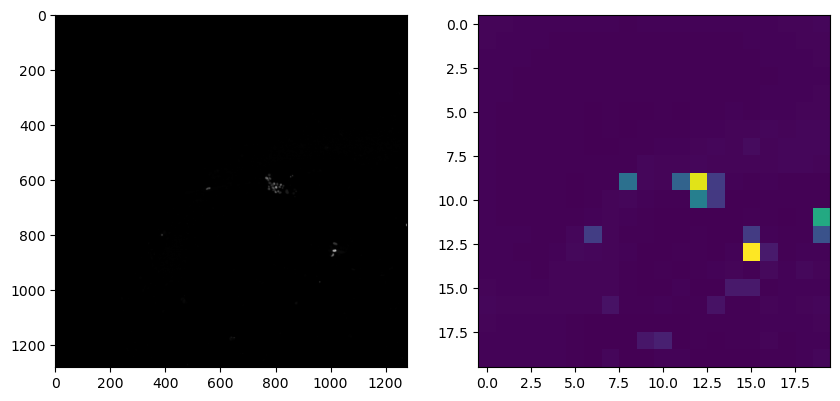

In [34]:
# Plot stds vs image
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img[:1280, :1280], cmap="gray")
ax[1].imshow(stds[:20, :20], cmap="viridis")

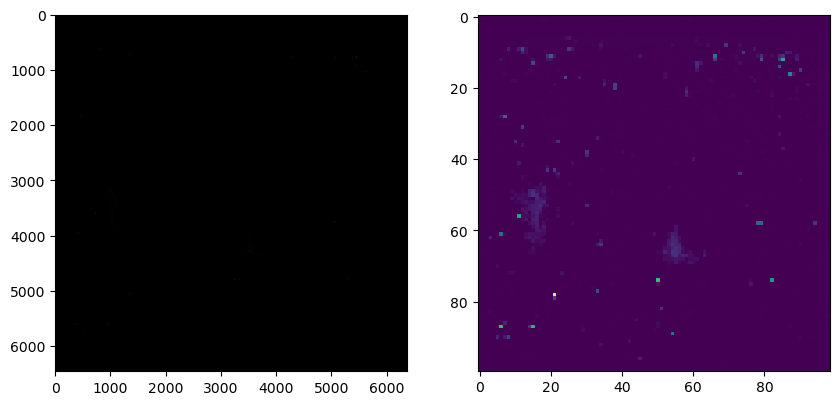

In [35]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img, cmap="gray")
ax[1].imshow(stds, cmap="viridis")

(array([  39.,   73.,  950., 2219., 2214., 1751., 1054.,  518.,  301.,
         148.,  108.,   55.,   38.,   18.,   11.,   17.,    6.,   12.,
           3.,    6.,    5.,    5.,    9.,    8.,    3.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ,
         4.4,  4.8,  5.2,  5.6,  6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,
         8.8,  9.2,  9.6, 10. ]),
 <BarContainer object of 25 artists>)

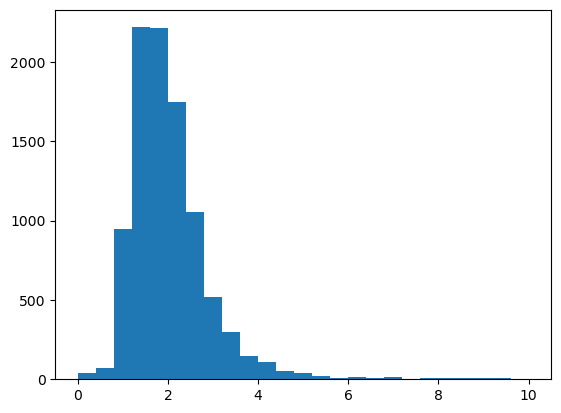

In [62]:
# make a 2D histogram of the stds
stds_flat = stds.flatten()
plt.hist(stds_flat, bins=25, range=(0, 10))

Keeping 13.07% of the patches


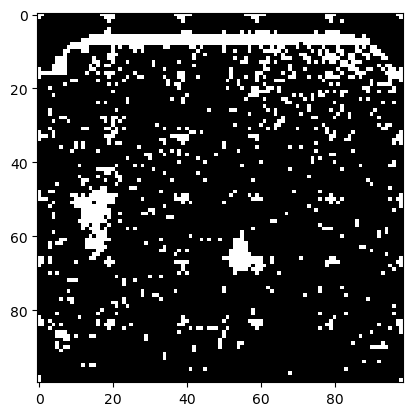

In [ ]:
background_threshold_std = 3
mask_std = stds > background_threshold_std
plt.imshow(mask_std, cmap="gray")
print(f"Keeping {(mask_std.sum() / mask_std.size * 100):.2f}% of the patches")

Potentially we can:
- Enlarge the patches to be sure that they contain all the cells
- Connected components to avoid cutting out some non-background regions
- Keep patches neighboring non-background patches
- Use some combinations of criteria to exclude patches

Note:
With `background_threshold==2` we can clearly see a checkerboard pattern in the mask.

In [57]:
means = np.mean(patches, axis=(2, 3))
print(means.shape)

(100, 99)


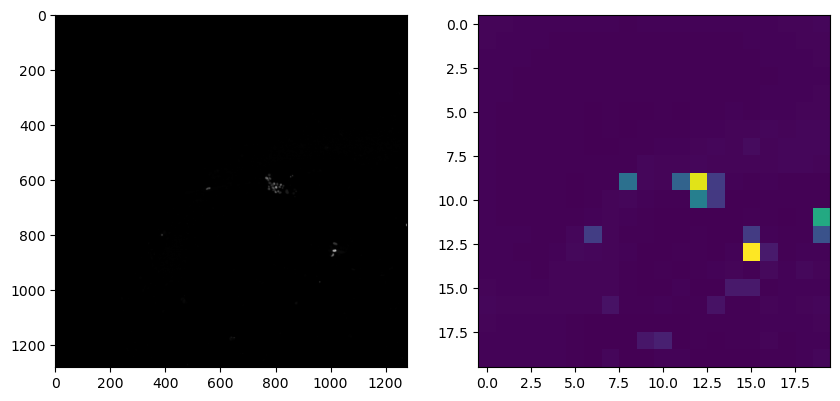

In [58]:
# Plot means vs image
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img[:1280, :1280], cmap="gray")
ax[1].imshow(stds[:20, :20], cmap="viridis")

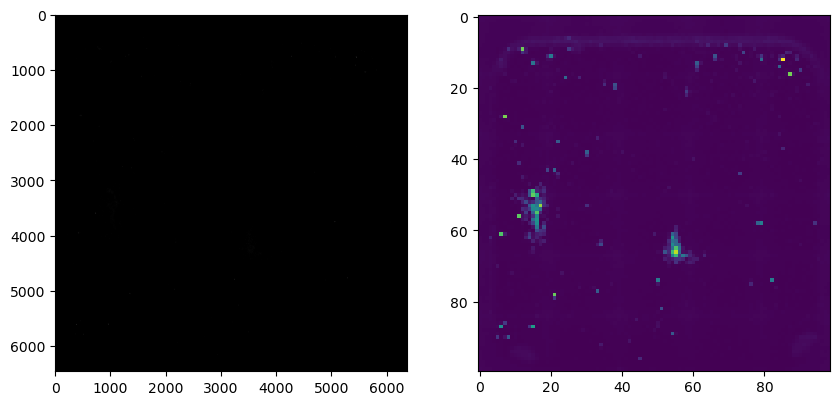

In [59]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img, cmap="gray")
ax[1].imshow(means, cmap="viridis")

(array([9.170e+02, 4.139e+03, 1.986e+03, 1.269e+03, 6.350e+02, 2.720e+02,
        8.100e+01, 5.900e+01, 6.500e+01, 4.200e+01, 4.100e+01, 3.000e+01,
        3.800e+01, 3.100e+01, 3.300e+01, 3.000e+01, 1.600e+01, 7.000e+00,
        9.000e+00, 7.000e+00, 1.200e+01, 2.000e+00, 3.000e+00, 1.100e+01,
        4.000e+00]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ,
         4.4,  4.8,  5.2,  5.6,  6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,
         8.8,  9.2,  9.6, 10. ]),
 <BarContainer object of 25 artists>)

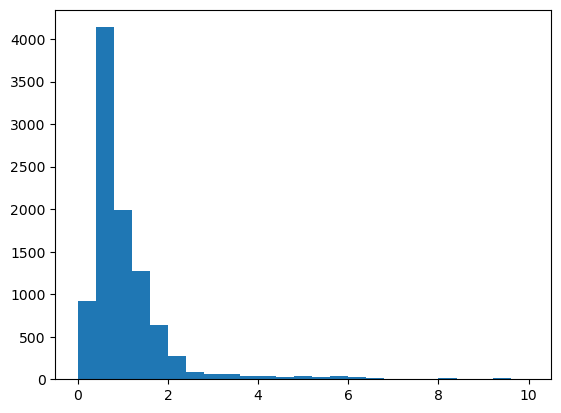

In [61]:
# make a 2D histogram of the means
means_flat = means.flatten()
plt.hist(means_flat, bins=25, range=(0, 10))

Keeping 9.63% of the patches


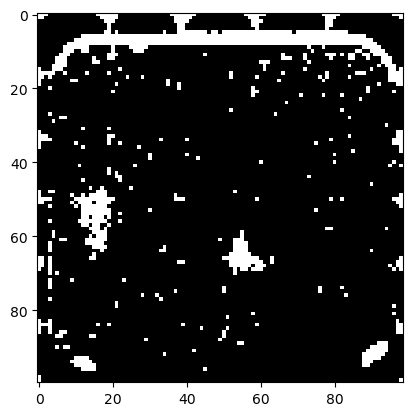

In [ ]:
background_threshold_mean = 2
mask_mean = means > background_threshold_mean
plt.imshow(mask_mean, cmap="gray")
print(f"Keeping {(mask_mean.sum() / mask_mean.size * 100):.2f}% of the patches")

#### Visualize some of the removed patches on higher side of std

In [82]:
mask_rm_high = np.logical_and(stds > 1.5, stds < 2)

Keeping 28.84% of the patches


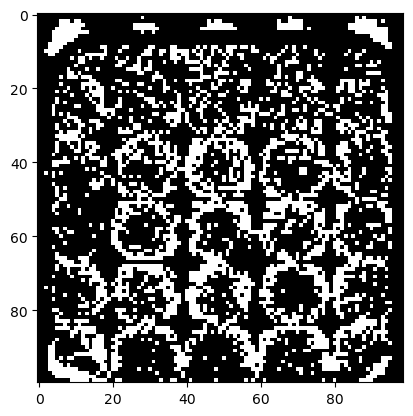

In [83]:
plt.imshow(mask_rm_high, cmap="gray")
print(f"Keeping {(mask_rm_high.sum() / mask_rm_high.size * 100):.2f}% of the patches")

Seems that there's a clear pattern in here...

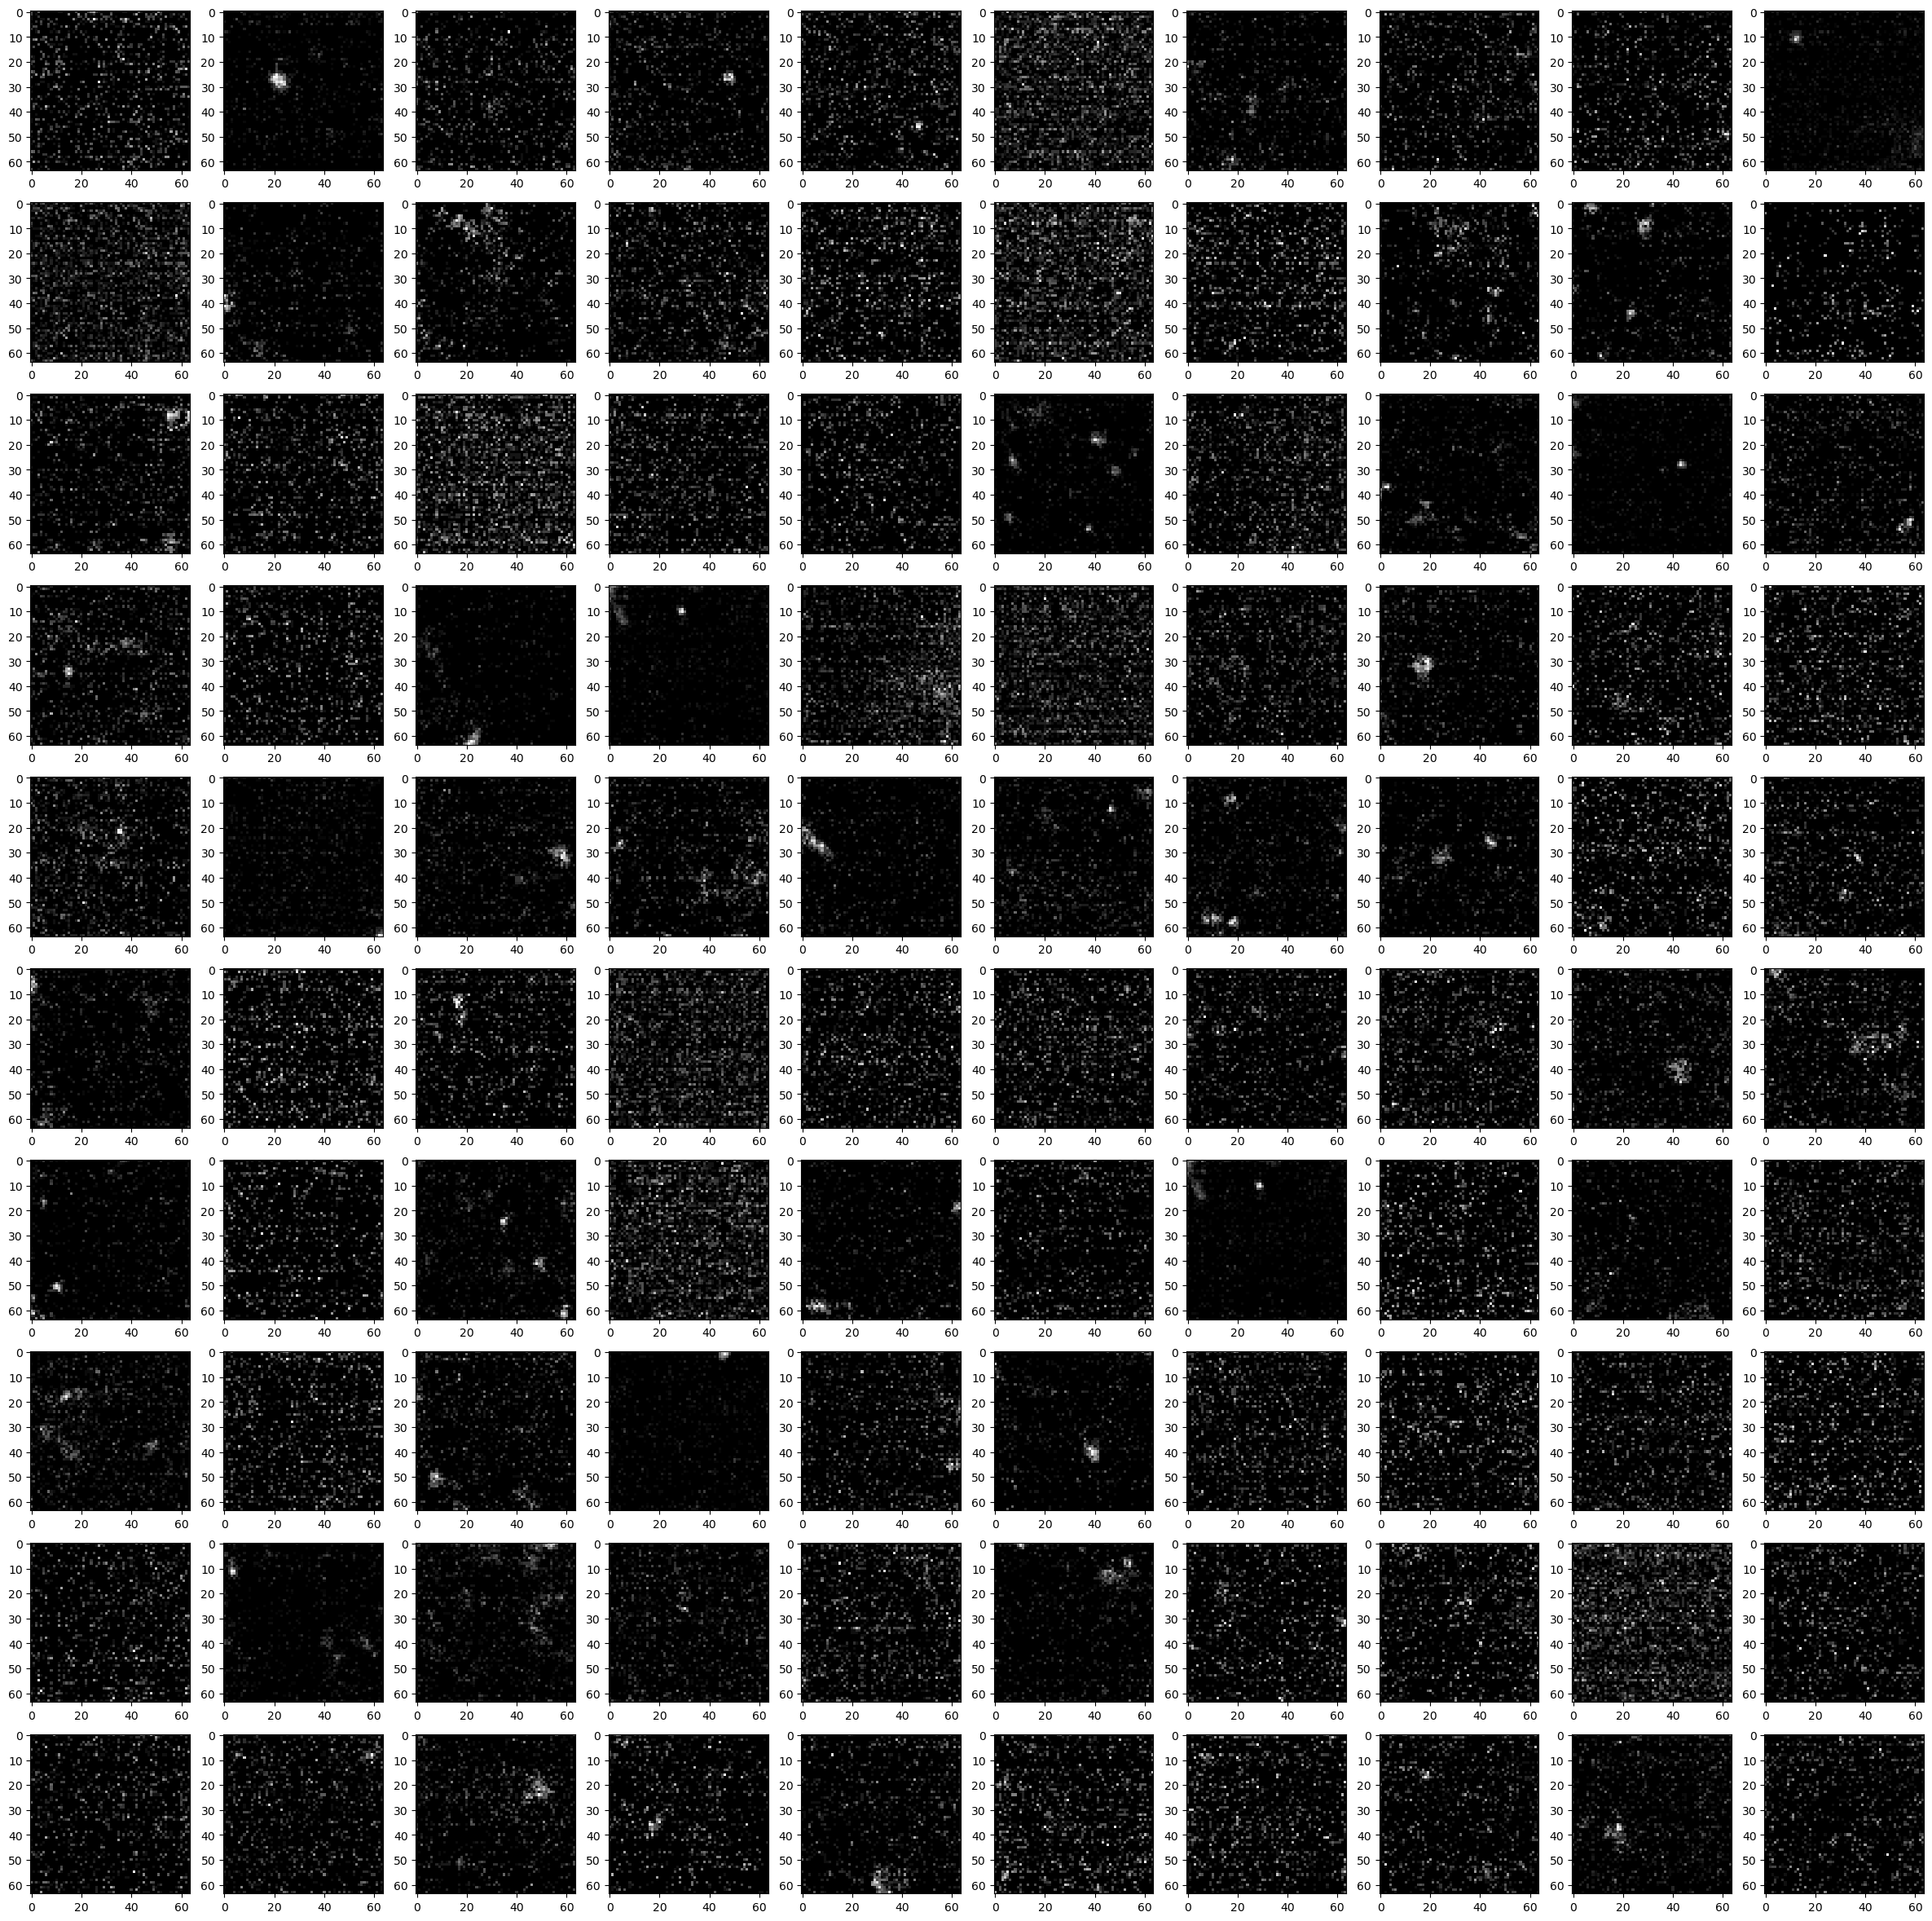

In [84]:
idxs = np.where(mask_rm_high)
_, ax = plt.subplots(10, 10, figsize=(30, 30))
for i in range(10):
    for j in range(10):
        idx = np.random.randint(idxs[0].size)
        ax[i, j].imshow(patches[idxs[0][idx], idxs[1][idx], ...], cmap="gray")

The simple standard deviation thresholding is getting rid of a lot of patches with structures. Specifically, we are talking about patches with low noise and few isolated particles in it.

Maybe a preprocessing step of denoising might be beneficial?